In [1]:
import pandas as pd
from tqdm.notebook import tqdm

df = pd.read_csv('Download/Cleaned Data/NoSleep.csv')
df

,created_utc,id,score,selftext,subreddit,title,title_language,selftext_language
0,1269397810,bhef5,24,Hey guys! Thanks for checking out /r/NoSleep! ...,nosleep,Welcome to /r/NoSleep!,nl,en
1,1269458850,bhq4w,68,This is copypasta from an earlier post... no w...,nosleep,The only possible supernatural experience I've...,en,en
2,1269476233,bhtlo,19,Reposting at the request of another. This was ...,nosleep,The Longhorn,en,en
3,1269479929,bhu80,29,"So, after looking at some other subreddits, I ...",nosleep,/r/NoSleep Rules,af,en
4,1269481302,bhufy,18,This is copy and pasted from the thread that s...,nosleep,My dad's story,cy,en
...,...,...,...,...,...,...,...,...
173274,1591452441,gxrm8v,1,"""Any sign of 'em yet?"" \n\nI continued staring...",nosleep,I'm tasked with killing nameless things out in...,en,en
173275,1591452568,gxrnj7,1,They say the devil is in the details. Well th...,nosleep,"I picked up a hitchhiker by mistake, now he's ...",en,en
173276,1591453707,gxrytp,1,It is hard for me to talk about my old friend ...,nosleep,My Best Friend Saw Bugs Under His Skin,de,en
173277,1591454493,gxs6jf,1,This is the only rule of our household. If you...,nosleep,Do NOT open your eyes. (The Beginning),en,en


In [15]:
sample = df.sample()['selftext']
encoded_string = sample.encode("ascii", "ignore")
sample = encoded_string.decode()
print(sample)

AttributeError: 'Series' object has no attribute 'encode'

In [151]:
for sent in nlp(nlp(sample)._.coref_resolved).sents:
    print(sent , '\n')
    
    for tok in sent:
        if tok.dep_ != "punct" and not tok.dep_.endswith('mod'):
            print(tok.text, tok.dep_)
    
    print('\n------------------\n')

This is a throwaway for personal reasons. 

This nsubj
is ROOT
a det
throwaway attr
for prep
reasons pobj

------------------

Warning also, there is tits and pussy mentioned in this post. 

Warning dep
there expl
is ROOT
tits attr
and cc
pussy nsubj
mentioned acl
in prep
this det
post pobj

------------------

If you don't like that stuff DO NOT READ ON - ABANDON ALL 

If mark
you nsubj
do aux
n't neg
like advcl
that det
stuff dobj
DO aux
NOT neg
READ ROOT
ON compound
ABANDON dobj
ALL dobj

------------------

HOPE 

HOPE ROOT

------------------

YE WHO ENTER HERE 

YE ROOT
WHO nsubj
ENTER relcl

------------------

- NSFWish - TURN BACK! 

 

NSFWish compound
TURN ROOT


 

------------------

So. 

So ROOT

------------------

I go to church because it's what people do around here. 

I nsubj
go ROOT
to prep
church pobj
because mark
it nsubj
's advcl
what dobj
people nsubj
do ccomp
around prep

------------------

But I don't like it and if I'm brutally honest 

But cc
I nsubj
do au

In [6]:
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
nlp = spacy.load('en')

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp)

In [3]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
#     doc = nlp(nlp(sent)._.coref_resolved)
    doc = nlp(sent)
    #############################################################
    
    pobj_cnt = 0
  
    for tok in doc:
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True and pobj_cnt < 1:
            ent2 = modifier +" "+ prefix +" "+ tok.text
            pobj_cnt += 1

          ## chunk 5  
          # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        #############################################################

    return [ent1.strip(), ent2.strip()]

In [4]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = spacy.matcher.Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [7]:
sample = '''
I guess this is it.\n\nI\'m posting this here in hopes that if this happens to the next person, proof will be left behind. I know I\'m not the first and I know I can\'t be the last. I know they\'re getting close to finding me.\n\nWhen I first started digging, I was content. Sure, it was hot but it was much better than being cooped up inside staring at the concrete walls. Inside that prison, you could be rewarded for good behavior. It\'s not a reward in the typical sense such as an extra meal, a warm beverage or a private shower. It\'s the ability to work. You can do some manual labor each and every day in exchange for some fresh air and a small sense of accomplishment. These tasks range from cooking, laundry or serving to making furniture, cleaning up trash or even digging holes.\n\nThere\'s only ever one digger and that was me. I helped the nearby farmers install large fences around their hundreds of acres of property. It was hard work. It was hot and humid and I only had access to a sliver of water when I worked. \n\nWhen he arrived, I thought I was hallucinating. After sixteen days in the arid summer, I thought my mind had finally turned to sludge. I looked up after he appeared to acknowledge me and I glared into his glassy grey eyes.\n\nHe was tall. I myself measure out at exactly six foot in height and he surpassed me by every bit of seven or eight inches! He wore a charcoal grey suit, white undershirt, dark black narrow tie and a pair of shoes so shiny you could see your reflection on the toe. His entire ensemble was accompanied by a bowler hat that he took off his head whenever he participated in conversation.\n\nHe introduced himself to me in a rather gentlemanly fashion and referred to himself as Mr. Samson. His face was a pure, pale white and underneath his hat he had a full head of grey and white speckled hair.\n\n"You must be the new digger," he said, retrieving a cigarette from the silver case in his jacket pocket.\n\n"I am. Are you the owner of the farm?" I asked. It was my best assumption considering the only people in the field other than myself were two guards who sat in the air conditioned van unless something was amiss.\n\n"No, I was a digger once," he said, and as he smirked he struck a match to light the cigarette now dangling from his mouth.\n\n"Ok then, nice to meet you." I looked down and began to dig again. As my shovel hit the dirt I felt a flurry of wind strike my face. As I looked up, Mr. Samson was squatting down next to me, inches from my face. I let out a small gasp and dropped my shovel.\n\n"Do you know why you are digging, son?" he asked, exhaling a puff of white smoke from his lips.  \n\n\n"Shit, man! I\'m digging for a fence. You\'re getting awfully close to me," I exclaimed, picking my shovel from the ground.\n\nMr. Samson stood up straight and ashed his cigarette. "That what they tell you? You\'re digging some holes for a fence? Why are they so deep? Why are these fence posts so deep, digger?"\n\nI looked back towards the rows of holes. No posts had been planted, at least in plain view. I dug these holes every eight feet. I would dig a small hole six feet deep, nearly straight down and at just enough of a slope to stand. They weren\'t wide but he was right, they were deep. I assumed that someone else was just a day or two behind me filling in the holes with concrete and posts.\n\n"You putting two and two together yet? You\'re digging graves, son," he said, tossing his butt into the partially dug dirt.\n\nAs I looked down at the wisps of flailing smoke, I asked, "If I\'m digging graves, why are they so narrow? Graves would be much wider. They\'re so deep because of the flat plains here. The wind comes through in a funnel and if they aren\'t seated very deep in the ground, the fence will be destroyed."\n\nI felt confident in my answer until I saw another smirk across his face. "They put them in standing up."\n\nAt that moment I heard the van door shut and the guards start to approach me quizzing me as to why I stopped digging. As I turned to look back at Mr. Samson, no one was there.\n\nAs the days went on, I laid awake many nights wondering if what he said was true. Mr. Samson would visit me every few days and our conversations were usually similar in topic. As we got closer to the red flags planted at the end of the farmer\'s property, I noticed the guards would watch me intently as they sat in the cool air and ate and listened to classic rock.\n\n"Today\'s the day," he said, seeming to appear out of thin air, as was his habit.\n\n"That I\'m finished? Yeah, a few more holes and I\'m sure then I\'ll be digging somewhere else. You\'ve kept me sane, Mr. Samson, even if you\'re a figment of my imagination," I said, wiping the sweat from my brow.\n\n"When you finish the last hole, make sure you\'re ready," he said, crushing his cigarette beneath his shoes.\n\nThat day, as I was nearing the end of my last hole, the guards came over to watch me. I figured they were going to escort me back to the van when I was finished but as I neared completion I heard a click as the guard to my left took his gun from his belt. I immediately ducked and swung my shovel, slicing the guard in his shins.\n\n"You motherfucker!" he yelled, reaching down to grab his bleeding leg. I snatched the gun from his hands and before the other guard could grab his weapon, I pointed it towards him.\n\nThe guards both stood, mouths agape. I ordered them to drop their weapons and call for someone immediately. Then a voice whispered in my ear.\n\n"Oh digger, you naive fool. What happens when someone arrives? Here you are, an inmate, waving a weapon at these guards. Who will they believe? The bleeding guard or the murderer?" he purred. I could see the sinister smile on his face in the corner of my eye.\n\nHe was right. If they contacted anyone, I was as good as dead.\n\n"I can\'t just kill them," I said, as grip of the pistol began to indent my palms, soaked with sweat. \n\n"You can. You can!" he said, standing to face me but off to the side as not to be in the way of a firing bullet. "They were going to kill you, you know."\n\n"You don\'t have to do this!" yelled one of the guards. "I have a family, man! Please don\'t do this. We won\'t even tell anyone, I swear to god man, please!" he began to beg. I knew it took everything inside him to stop from weeping\n\n"He\'s lying. Do what he was going to do to you, digger. Fill these holes with something other than yourself!" he yelled, ashes flying in the breeze. \n\nAs my mind began to race, I felt my heart beat in my throat. The metallic scent of blood pounded in my nose. I needed water. More than anything I wanted to stop this madness and drink until the burning in my throat subsided and I could think clearly.\n\nI dragged my free hand across my face, frustrated with my predicament. When I saw again from behind my hand it looked as if the guard was reaching for his radio. In a split second, I fired. Then as the pained gasp from the guard\'s mouth reached my ears, I fired again. Only this time, towards the other guard.\n\nAs I watched their helpless sacks of meat flail to the ground I looked towards Mr. Samson, in his nice suit now flaked with blood splatter.\n\n"Good job, son. You only have several hundred to go!" he exclaimed, putting a hand on my shoulder and waving the other one towards the long line of other holes.\n\nI\'ve been on the run ever since.
'''
doc = nlp(sample)
entity_pairs = []

for i in tqdm([sent for sent in doc.sents]):
    entity_pairs.append(get_entities(str(i)))

  0%|          | 0/128 [00:00<?, ?it/s]

In [8]:
relations = [get_relation(str(i)) for i in tqdm([sent for sent in doc.sents])]

  0%|          | 0/128 [00:00<?, ?it/s]

In [9]:
pd.Series(relations).value_counts()[:50]

was                  7
"                    6
said                 5
looked               4
know                 4
's                   3
yelled               3
asked                3
was hot              2
are                  2
digging              2
began                2
do                   2
have                 2
stood                2
was right            2
fired                2
thought              2
felt                 2
exclaimed            1
wore                 1
're                  1
ordered              1
knew                 1
Shit                 1
squatting            1
purred               1
were deep            1
have several         1
getting              1
can                  1
range from           1
surpassed            1
guard                1
rewarded for good    1
was hard             1
am                   1
assumed              1
measure              1
job                  1
were                 1
needed               1
put                  1
Ok         

In [10]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'original sent': [sent.text for sent in doc.sents], 'source':source, 'target':target, 'edge':relations})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
kg_df

,original sent,source,target,edge
0,\nI guess this is it.\n\n,this,,guess
1,"I'm posting this here in hopes that if this happens to the next person, proof will be left behind.",next proof,this,posting
2,I know I'm not the first,I,,know
3,and I know I can't be the last.,I,,know
4,I know they're getting close to finding me.\n\n,they,me,know
5,"When I first started digging, I was content.",first I,,was content
6,"Sure, it was hot",it,,was hot
7,but it was much better than being cooped up inside staring at the concrete walls.,it,much staring,was
8,"Inside that prison, you could be rewarded for good behavior.",you,prison,rewarded for good
9,"It's not a reward in the typical sense such as an extra meal, a warm beverage or a private shower.",It,typical sense,'s


In [11]:
for tok in nlp("Warning also, there is tits and pussy mentioned in this post."):
    print(tok.text, tok.dep_)

Warning nsubj
also advmod
, punct
there expl
is ROOT
tits attr
and cc
pussy conj
mentioned acl
in prep
this det
post pobj
. punct


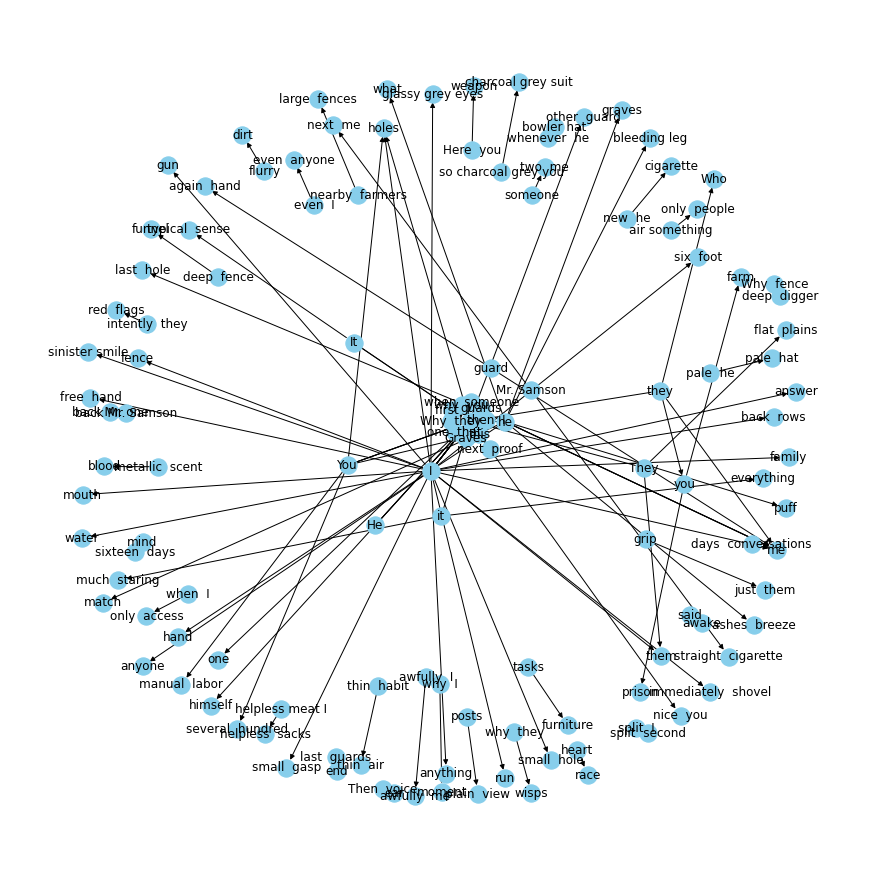

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

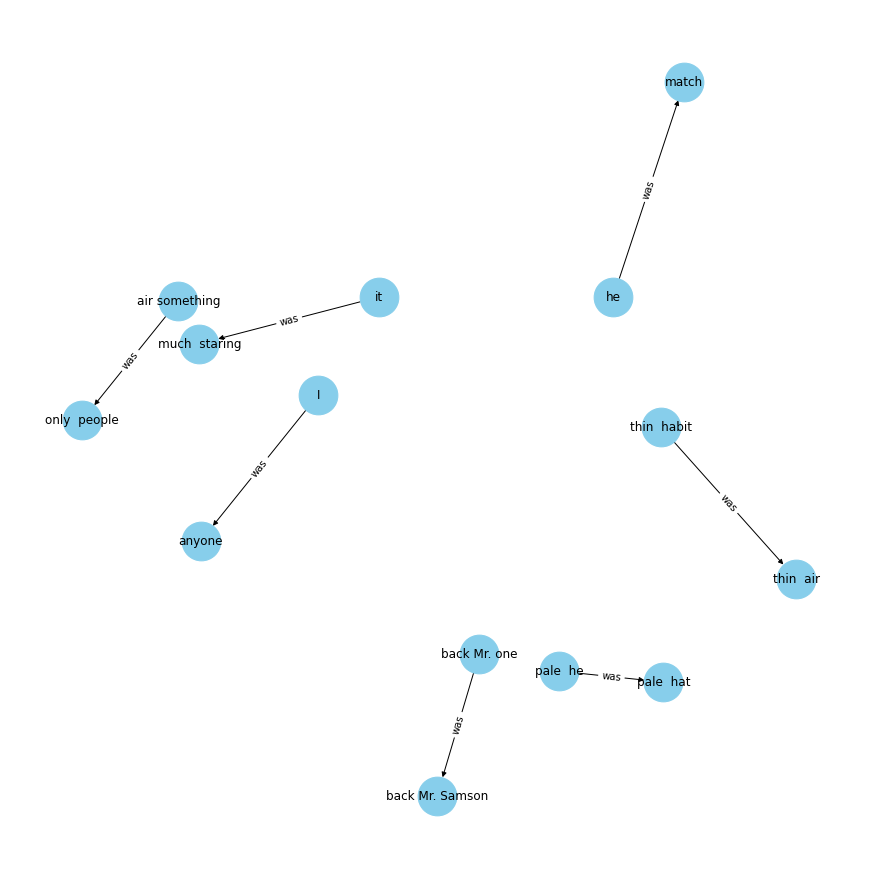

In [14]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
edge_labels = nx.get_edge_attributes(G,'edge')
for old_key in list(edge_labels):
    new_key = old_key[:2]
    edge_labels[new_key] = edge_labels.pop(old_key)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

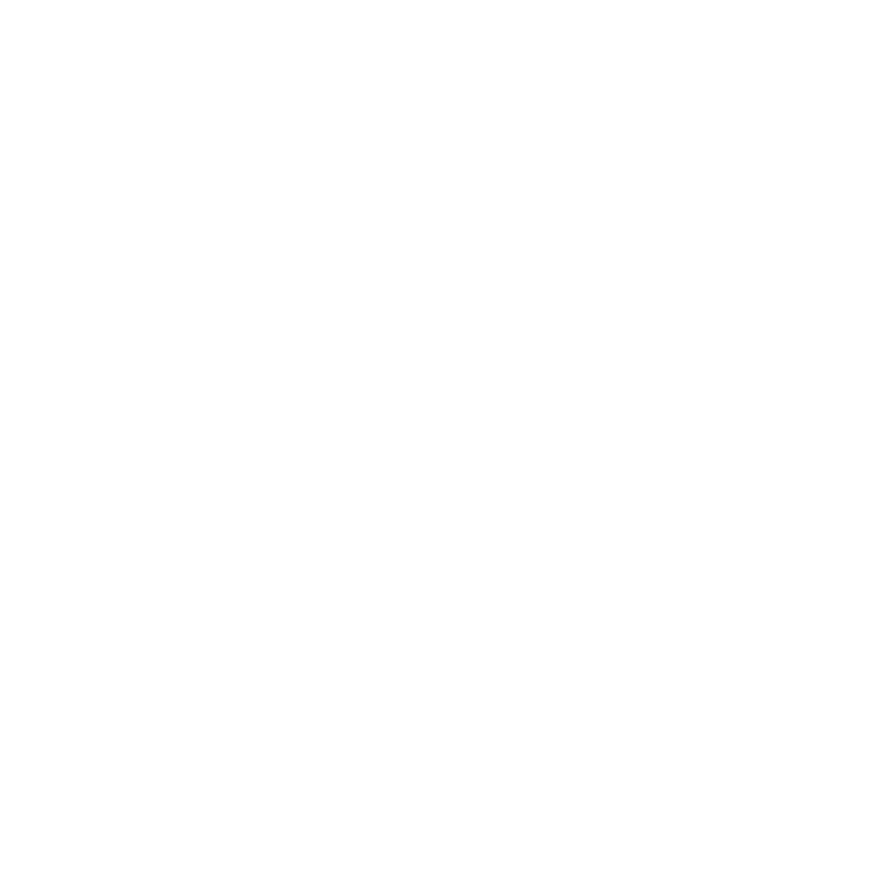

In [206]:
G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="her"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
edge_labels = nx.get_edge_attributes(G,'edge')
for old_key in list(edge_labels):
    new_key = old_key[:2]
    edge_labels[new_key] = edge_labels.pop(old_key)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [2]:
import spacy
print(spacy.__version__)

2.3.5


In [128]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)


def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', ' ', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs]
#                           if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

In [129]:
pairs = get_entity_pairs(sample)
pairs

Entity pairs extracted: 10


,subject,relation,object,subject_type,object_type
0,,had,small shopping complex,NOUN_CHUNK,NOUN_CHUNK
1,,stare out,bedroom window,NOUN_CHUNK,NOUN_CHUNK
2,,scared,,NOUN_CHUNK,NOUN_CHUNK
3,,seen,cave complex,NOUN_CHUNK,NOUN_CHUNK
4,,caught,attention,NOUN_CHUNK,NOUN_CHUNK
5,,have,care,NOUN_CHUNK,NOUN_CHUNK
6,,made,,NOUN_CHUNK,NOUN_CHUNK
7,joggers,gave,strange looks,NOUN_CHUNK,NOUN_CHUNK
8,,entered,world,NOUN_CHUNK,NOUN_CHUNK
9,mum,believe,,NOUN_CHUNK,NOUN_CHUNK


In [99]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

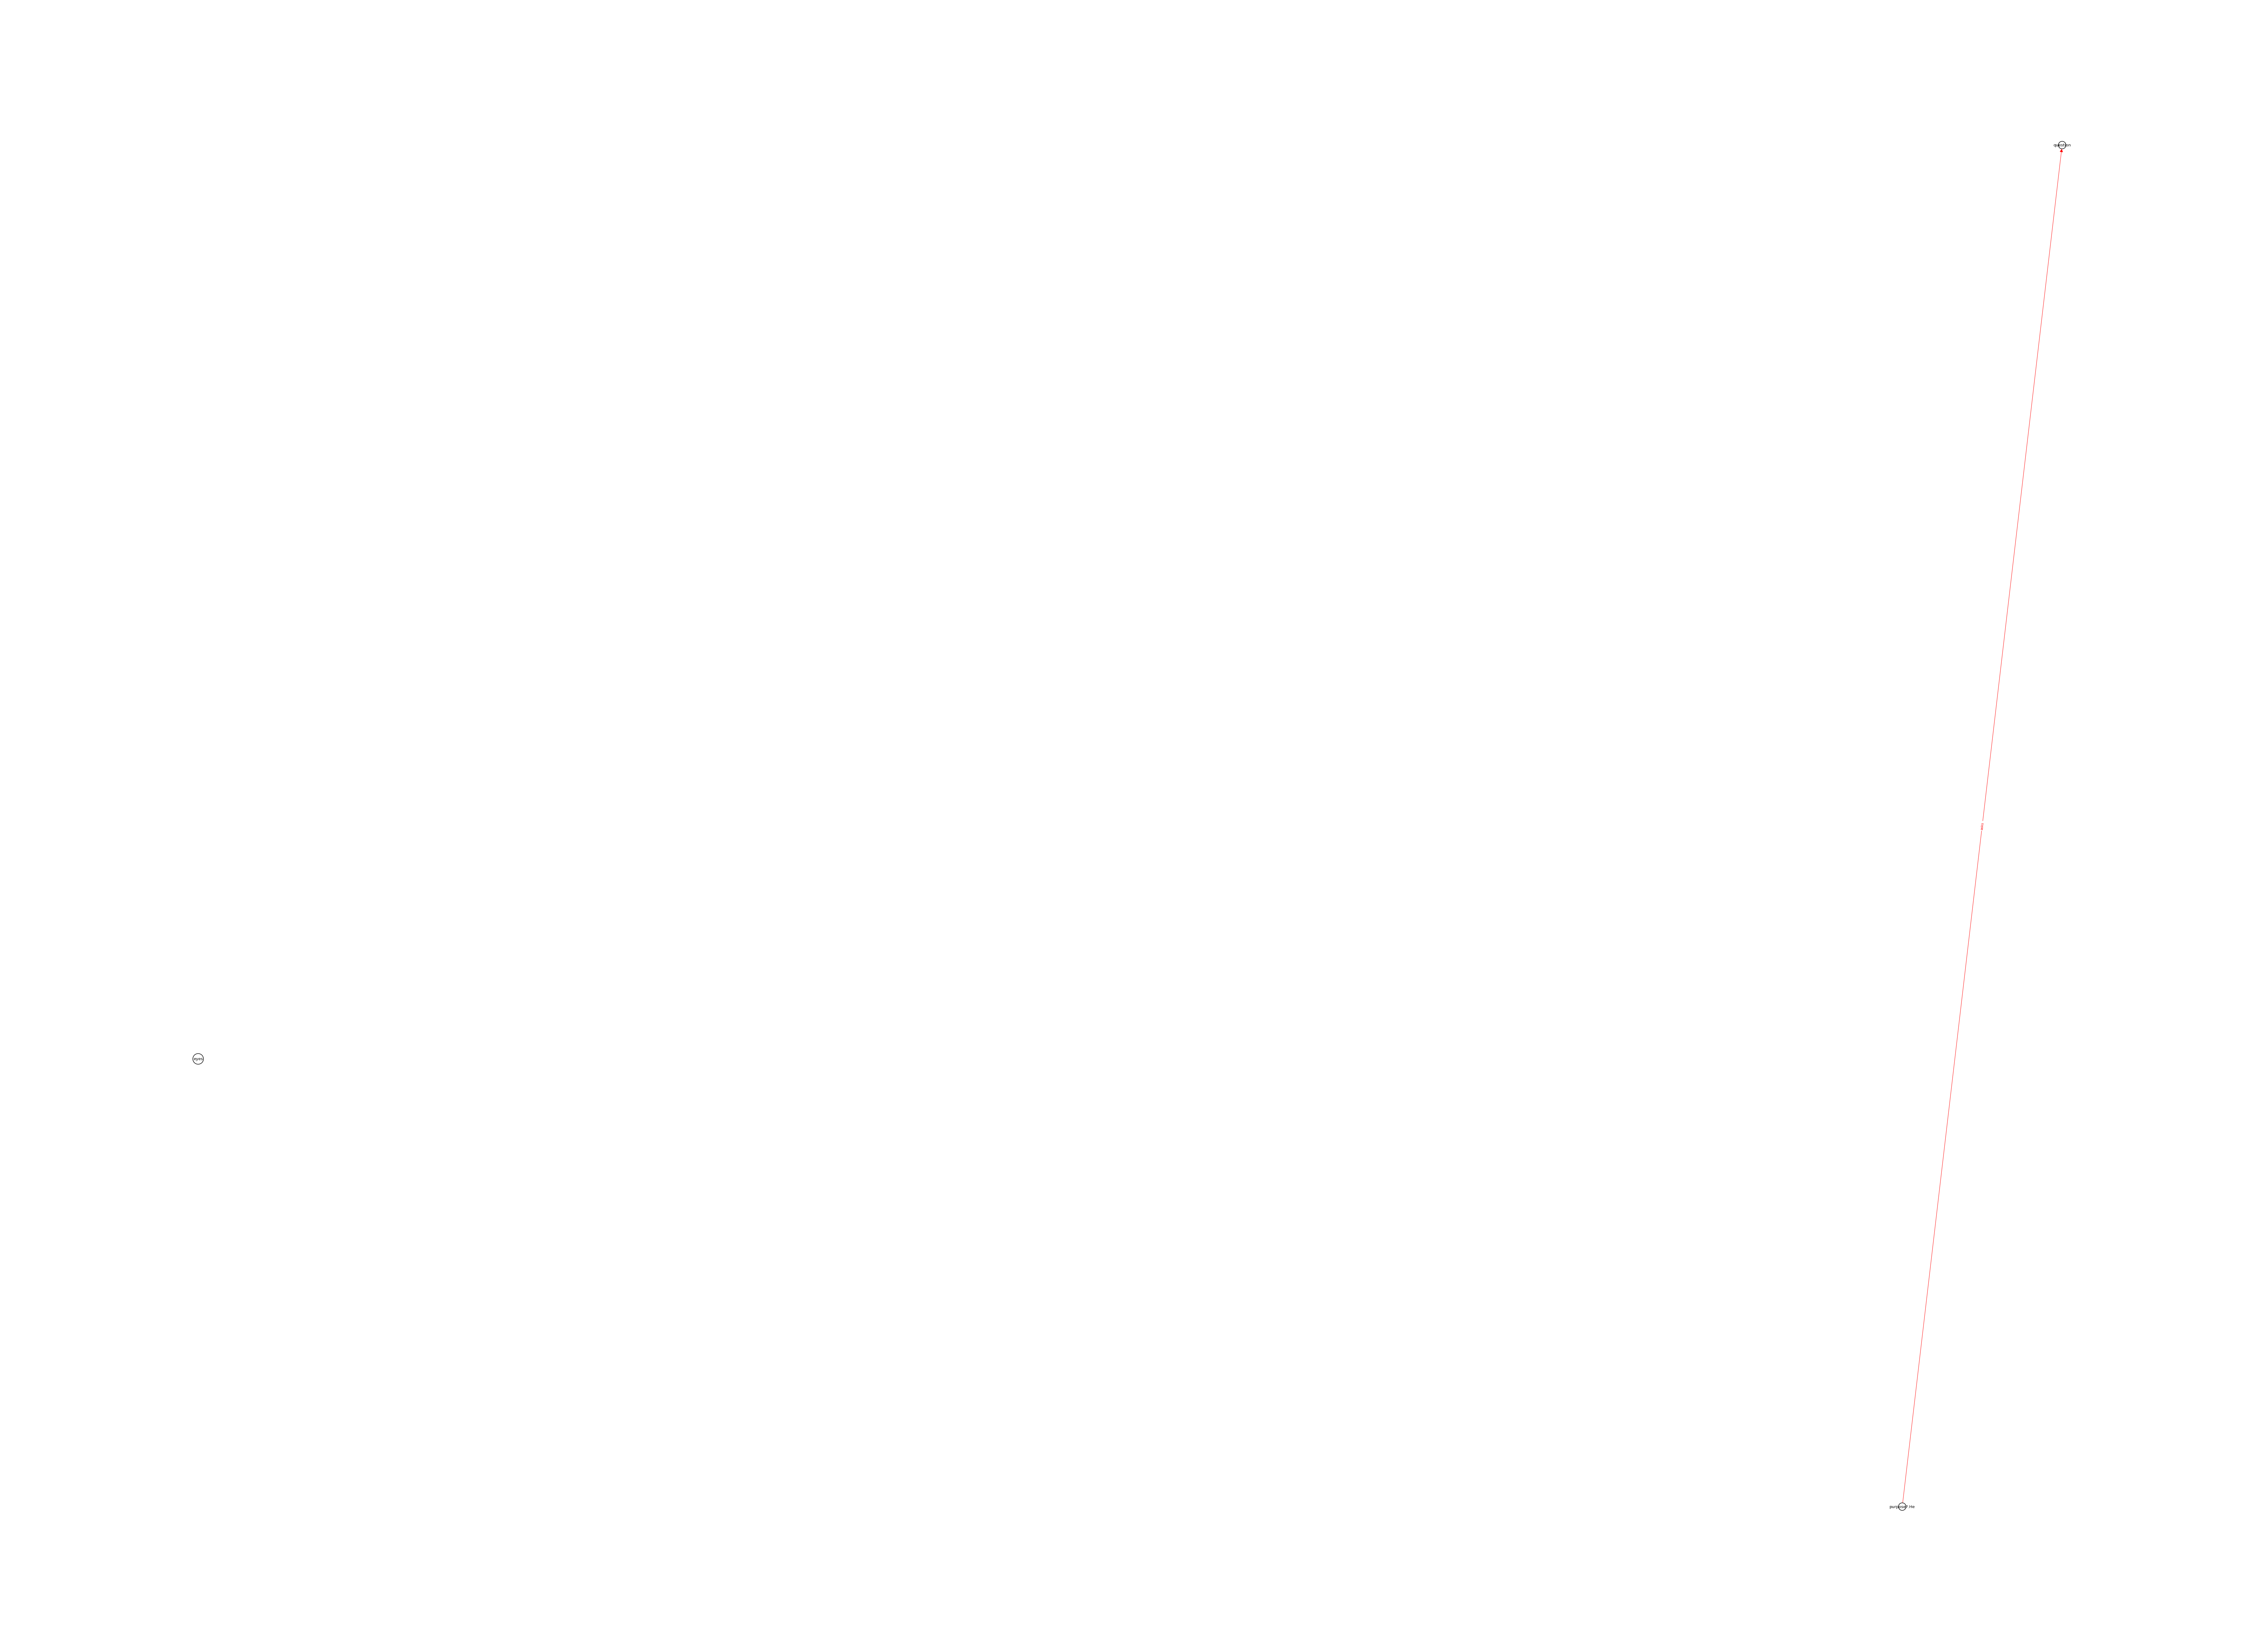

In [100]:
draw_kg(pairs)

In [189]:
from openie import StanfordOpenIE


df_li = []

for sent in doc.sents:
    with StanfordOpenIE() as client:
        for triple in client.annotate(sent.text):
            triple['original sent'] = sent.text
            df_li.append(triple)
            
pd.DataFrame(df_li)

Starting server with command: java -Xmx8G -cp /home/anthony/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f21068a9bc2a4499.props -preload openie
Starting server with command: java -Xmx8G -cp /home/anthony/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-59ff9154f78040e8.props -preload openie
Starting server with command: java -Xmx8G -cp /home/anthony/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-934df88b57374d72.props -preload openie
Starting server with command: java -Xmx8G -cp /home/anthony/stanfordnlp_reso

,subject,relation,object,original sent
0,tits pussy,mentioned in,post,"Warning also, there is tits and pussy mentioned in this post."
1,I,go,it 's,I go to church because it's what people do around here.
2,I,go to,church,I go to church because it's what people do around here.
3,shot,is in,big guy 's shoes,Sometimes I think I could do a lot better if I was given a shot in the big guy's shoes.
4,big guy,in,shoes,Sometimes I think I could do a lot better if I was given a shot in the big guy's shoes.
5,film,is with,Jim Carey,Like that film with Jim Carey where he gets to be God for a day.
6,he,gets,God,Like that film with Jim Carey where he gets to be God for a day.
7,he,be God for,day,Like that film with Jim Carey where he gets to be God for a day.
8,he,gets,God for day,Like that film with Jim Carey where he gets to be God for a day.
9,he,be,God,Like that film with Jim Carey where he gets to be God for a day.


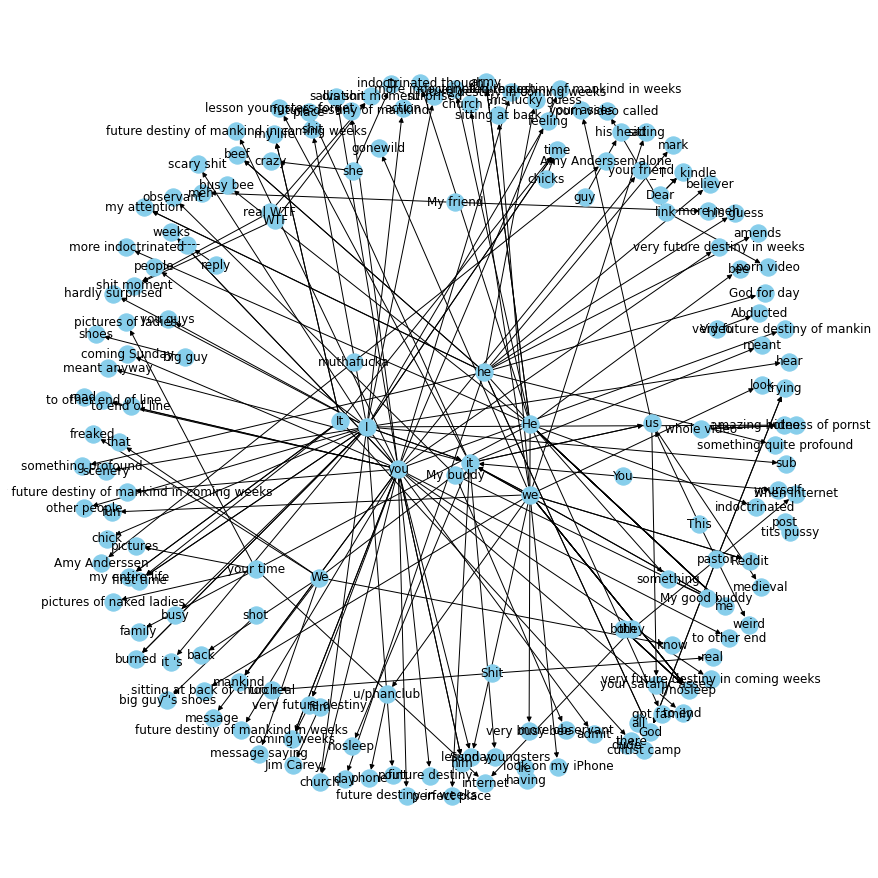

In [193]:
import networkx as nx
import matplotlib.pyplot as plt
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(pd.DataFrame(df_li), "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [191]:
kg_df

,original sent,source,target,edge
0,This is a throwaway for personal reasons.,This,personal reasons,is
1,"Warning also, there is tits and pussy mentioned in this post.",Warning,also post,is
2,If you don't like that stuff,you,stuff,like
3,DO NOT READ ON - ABANDON,,ON ABANDON,READ
4,ALL HOPE YE WHO ENTER HERE - NSFWish - TURN BACK! \n\n,HOPE WHO,HERE NSFWish BACK,YE
5,So.,,,So
6,I go to church because it's what people do around here.,people,church,go to
7,But I don't like it and if I'm brutally honest (and this is hard for me to say in a public forum),me,it,like
8,I don't believe much in God.,I,much,believe much
9,"I mean, I don't think I could ever be a full on atheist because I do have a relationship with the dude - as they say",they,ever atheist,think
